In [40]:
import MySQLdb
import torch
import numpy as np
import matplotlib.pyplot as plt
import math

In [65]:
def loadKline(code):
    db = MySQLdb.connect("localhost", "root", "789", "stock", charset='utf8',port=3307 )
    db.query("""select * from company where code='%s'"""%code)
    r = db.store_result()
    company = r.fetch_row()
    db.query("""select volume,open,high,low,close,macd from kd_xueqiu where id=%s"""%company[0][0])
    r = db.store_result()
    k = r.fetch_row(r.num_rows())
    db.close()
    kline = torch.tensor(k).reshape(-1,6)
    return company,kline

In [136]:
"""计算指数移动平均线ema,公式来源于baidu"""
def ema(k,n):
    m = torch.zeros(len(k))
    for i in range(len(k)):
        if i==0:
            m[0] = k[i,4]
        else:
            m[i] = (2*k[i,4]+(n-1)*m[i-1])/(n+1)
    return m    
"""计算macd
DIF=EMA(close，12）-EMA（close，26)
DEA=EMA(DIF,9)
MACD=(DIF-DEA)*2
展开得到
MACD=224/51*EMA(close,9)-16/3*EMA(close,12)+16/17*EMA(close,26)
"""
def macd(k):
    ema9 = ema(k,9)
    ema12 = ema(k,12)
    ema26 = ema(k,26)
    return 224.*ema9/51.-16.*ema12/3.+16.*ema26/17.

"""计算kdj
n日RSV=（Cn－Ln）/（Hn－Ln）×100
公式中，Cn为第n日收盘价；Ln为n日内的最低价；Hn为n日内的最高价。
"""
def kdj(k,n):
    kdj = torch.zeros(len(k),3) #K,D,J
    for i in range(len(k)):
        if i-n+1>=0:
            prevn = k[i-n+1:i+1,1:4]
        else:
            prevn = k[0:i+1,1:4]
        Ln = prevn.min()
        Hn = prevn.max()
        rsv = (k[i,4]-Ln)*100./ (Hn-Ln)
        if i>=1:
            kdj[i,0] = 2.*kdj[i-1,0]/3.+rsv/3.
            kdj[i,1] = 2.*kdj[i-1,1]/3.+kdj[i,0]/3.
        else:
            kdj[i,0] = 2.*50./3.+rsv/3.
            kdj[i,1] = 2.*50./3.+kdj[i,0]/3.            
        kdj[i,2] = 3.*kdj[i,0]-2.*kdj[i,1]        
    return kdj

"""计算均线 n 表示多少日均线"""
def ma(k,n):
    m = torch.zeros(len(k))
    for i in range(len(k)):
        if i-n+1>=0:
            m[i] = k[i-n+1:i+1,4].sum()/n
        else:
            m[i] = k[0:i+1,4].sum()/(i+1)
    return m

In [150]:
c,kline = loadKline('SZ399001')

In [142]:
def showMA(k,ma,bi,ei):
    x = np.linspace(bi,ei,ei-bi+1)
    plt.plot(x,k[bi:ei+1,6],label="ma5",color='red')
    plt.plot(x,ma[bi:ei+1],label="cma5",color='blue')
    plt.show()
def showMACD(k,ma,bi,ei):
    x = np.linspace(bi,ei,ei-bi+1)
    plt.plot(x,k[bi:ei+1,5],label="macd",color='red')
    plt.plot(x,ma[bi:ei+1],label="mymacd",color='blue')
    plt.show()
def showKDJ(k,kdj,bi,ei):
    widths = [1]
    heights = [3,1]
    gs_kw = dict(width_ratios=widths, height_ratios=heights)      
    fig, axs = plt.subplots(2, 1, figsize=(28, 16),gridspec_kw = gs_kw)
    x = np.linspace(bi,ei,ei-bi+1)
    
    axs[0].scatter(x,k[bi:ei+1,4],label="kline",color='orange')
    axs[0].grid(True)
    
    axs[1].plot(x,kdj[bi:ei+1,0],label="K",color='orange')
    axs[1].plot(x,kdj[bi:ei+1,1],label="D",color='blue')
    axs[1].plot(x,kdj[bi:ei+1,2],label="J",color='purple')
    axs[1].grid(True)
    plt.show()

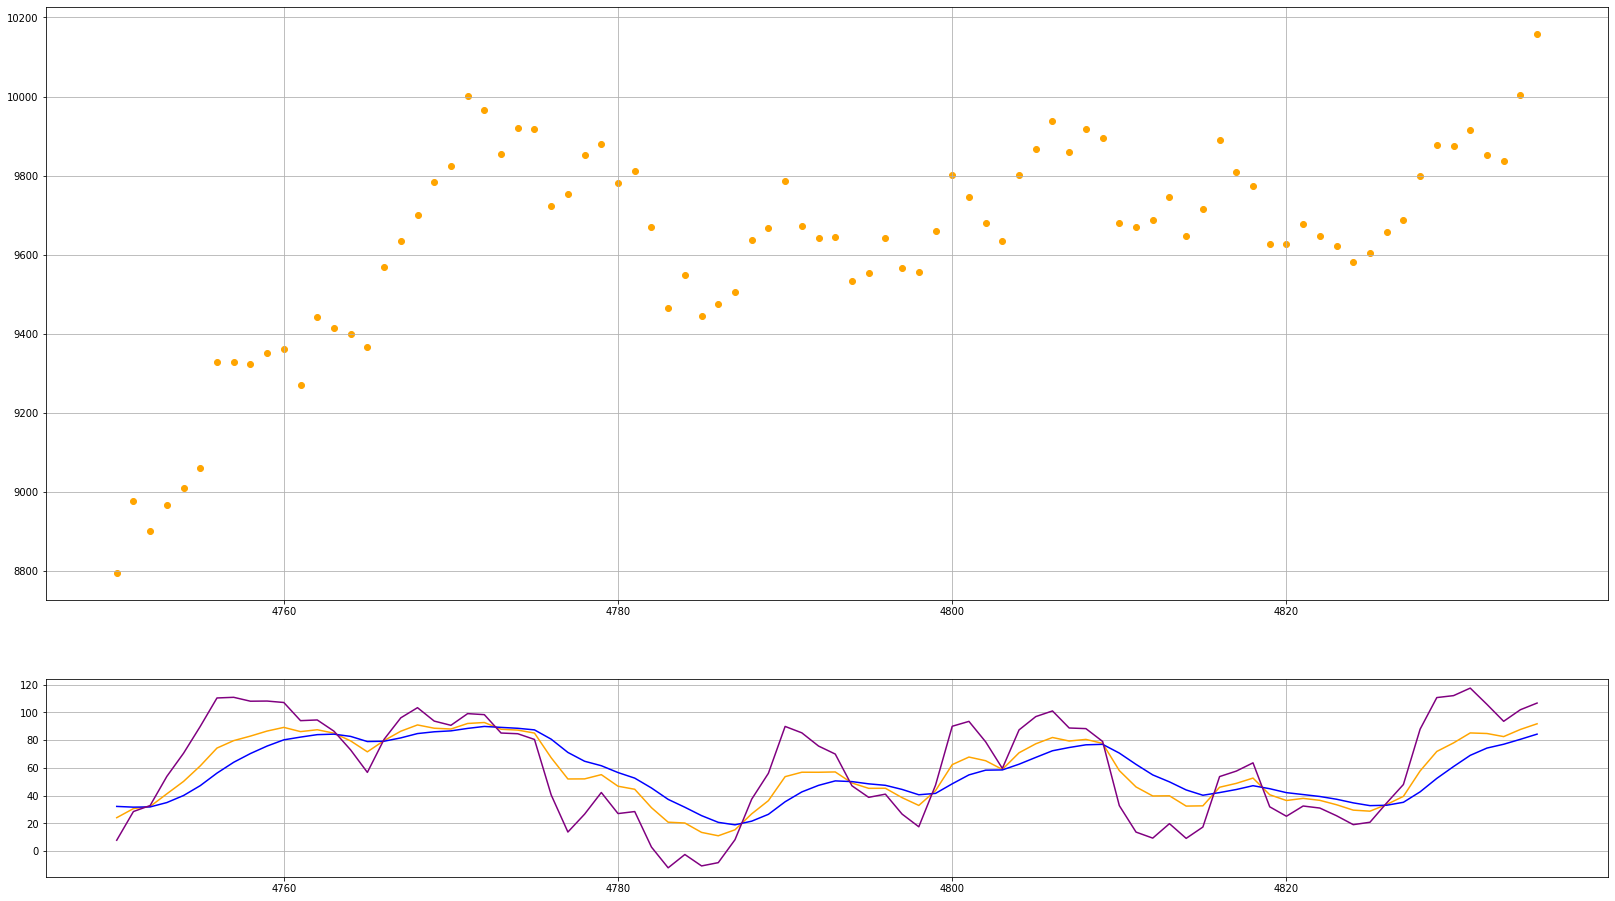

In [151]:
kdJ = kdj(kline,9)
showKDJ(kline,kdJ,4750,4835)

In [98]:
len(kline)

4836